# Code and process of  the  exact Riemann solver and test examples.

## 1. possible cases

If we consider all the elastic and plastic waves, there are 6*6  possible cases. For simple, we only  consider the cases in the left side and samilar process will be taken in the right.
<img src="Case1.png" width = "350" height = "350" div align=center />
<center> Case 1
<img src="Case2.png" width = "350" height = "350" div align=center />
    Case 2
    <img src="Case3.png" width = "350" height = "350" div align=center />
    Case 3
<img src="Case4.png" width = "350" height = "350" div align=center />
    Case 4


In [31]:
using Distributed
#addprocs(1)

In [32]:
#procs(2)

In [33]:
struct Const
    Y0 ::Float64
    ρ0 ::Float64
    Γ0 ::Float64
    μ  ::Float64
    a0 ::Float64
    s0 ::Float64
end
    

struct Var
    ρ ::Float64
    u ::Float64
    p ::Float64
    sxx::Float64
end



$$f(\eta) = \frac{(\eta-1)(\eta-\Gamma_0(\eta-1)/2)}{(\eta-s_0(\eta-1))^2}$$
$$f'(\eta) = \frac{\eta+(s_0-\Gamma_0)(\eta-1)}{(\eta-s_0(\eta-1))^3}$$

In [34]:
function fη(ρ::Float64,c::Const)
    η = ρ/c.ρ0
    fη=(η-1.0)*(η-c.Γ0*(η-1.0)/2.0)/(η-c.s0*(η-1))^2
end

function fηη(ρ::Float64,c::Const)
    η = ρ/c.ρ0
    fηη=(η+(c.s0-c.Γ0)*(η-1))/(η-c.s0*(η-1))^3
end

fηη (generic function with 1 method)

$$ c=\sqrt{a^2-\frac{\rho_0}{\rho^2}\Gamma_0s_{xx}+\frac{4}{3}\frac{\mu}{\rho}}$$
$$ a^2= a_0^2 f'(\eta)+\frac{p}{\rho^2}\rho_0\Gamma_0$$

if $|s_{xx}| \ge \frac{2}{3}Y_0$ then sound speed is change to 
$$ c=\sqrt{a^2-\frac{\rho_0}{\rho^2}\Gamma_0s_{xx}}$$

In [35]:
function sound(uo::Array{Float64,1},con::Const,EoP::Int=1)
    a0  = con.a0
    ρ0  = con.ρ0
    Γ0  = con.Γ0
    Y0  = con.Y0
    μ   = con.μ
    ρ   = uo[1]
    uu  = uo[2]
    p   = uo[3]
    sxx = uo[4]
    a2  = a0^2*fηη(ρ,con)+p/ρ^2*ρ0*Γ0
  #  c = ftest(a2,ρ0,ρ,Γ0,sxx,μ,a0,fηη(ρ,con),p)
    if EoP == 2
        c=sqrt(a2-ρ0/ρ^2*Γ0*sxx)
        return c
    else
        c=sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
        return c
    end
end

function sound(U::Const,con::Const,EoP::Int = 1)
    a0,ρ0,Γ0,μ,Y0 = con.a0, con.ρ0, con.Γ0, con.μ,con.Y0
    ρ,u,p,sxx    = U.ρ, U.u,U.p,U.sxx
    a2  = a0^2*fηη(ρ,con)+p/ρ^2*ρ0*Γ0 
    if EoP == 2
        c=sqrt(a2-ρ0/ρ^2*Γ0*sxx)
        return c
    else
        c=sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
        return c
    end
end


sound (generic function with 4 methods)

Mie-Gr\"uneisen equation of state
$$e =\frac{p-\rho_0a_0^2f(\eta)}{\rho_0\Gamma_0}$$

$$p = \rho_0a_0^2f(\eta)+\rho_0\Gamma_0e$$

In [36]:
function PToe(ρ::Float64,p::Float64,con::Const)
    c=con
    ei = (p-c.ρ0*c.a0^2*fη(ρ,c))/(c.ρ0*c.Γ0)
    return ei
end
function EToP(ρ::Float64,ei::Float64,con::Const)
    c=con
    p = c.ρ0*c.Γ0*ei+c.ρ0*c.a0^2*fη(ρ,c)
    return p
end

EToP (generic function with 1 method)

## 2.Using a HLLCE process  ro pre-evaluate
consider a two shock wave case
<img src="Case5.png" width = "350" height = "350" div align=center />
 <center>   With only plastic or plastic shock wave

 using the relation of $u_L^* =u_R^* = s^*$, the speed of contact wave can be evaluated as
\begin{equation}
 \hat{s}^* = \frac{\sigma_L-\sigma_R+\rho_L u_L(s_L-u_L)-\rho_R u_R(s_R-u_R)}{\rho_L(s_L-u_L)-\rho_R(s_R-u_R)},
\end{equation}
the density is solved as
\begin{equation}\label{eq:rhoLs}
  \hat{\rho}_L^* = \frac{\rho_L(u_L-s_L)}{\hat{s}^*-s_L}.
\end{equation}
Similarly, the density behind the right going wave can be given as
\begin{equation}
  \hat{\rho}_R^* = \frac{\rho_R(u_R-s_R)}{\hat{s}^*-s_R}.
\end{equation}



The deviatoric stress is evaluated as
\begin{equation}  \label{sxx1}
  \hat{s}_{xxL}^*=-\frac{4}{3}\mu\text{ln}(\frac{\hat{\rho}_L^*}{\rho_L})+s_{xxL}, \quad   \hat{s}_{xxR}^*=-\frac{4}{3}\mu\text{ln}(\frac{\hat{\rho}_R^*}{\rho_R})+s_{xxR}.
\end{equation}

If the speeds of left and right going waves are given, we can evaluate all states in the star regions on the two sides of  the contact wave. Here we define the speeds of left and right going waves as
    \begin{equation}
      s_L = \text{min} (u_L-c_L, u_R-c_R, 0),  \quad s_R = \text{max}(u_L+c_L, u_R+c_R, 0).
    \end{equation}


In [37]:
function Presolve(varL::Var, varR::Var, conL::Const,conR::Const)
        
    ρL, uL, pL, sxxL = varL.ρ, varL.u, varL.p, varL.sxx
    ρR, uR, pR, sxxR = varR.ρ, varR.u, varR.p, varR.sxx
    σL  = -pL+sxxL
    
    UL = [ρL, uL, pL, sxxL]
    UR = [ρR, uR, pR, sxxR]
    cL = sound(UL[:],conL)
    
    σR  = -pR+sxxR
    cR = sound(UR[:],conR)

    
    sL = min(uL-cL, uR-cR)
    sR = max(uL+cL, uR+cR)
        
    s_star = (σL - σR + ρL*uL*(sL-uL) - ρR* uR*(sR-uR))/(ρL*(sL-uL)-ρR*(sR-uR))
        
    ρLstar = ρL*(uL-sL)/(s_star - sL)
    ρRstar = ρR*(uR-sR)/(s_star - sR)
        
    sxxLstar =  sxxL -4/3*conL.μ *(log(ρLstar) - log(ρL))
    sxxRstar =  sxxR -4/3*conR.μ *(log(ρRstar) - log(ρR))

    caseL = CaseSelect(sxxL,sxxLstar, ρL, ρLstar,conL,1)
    caseR = CaseSelect(sxxR,sxxRstar, ρR, ρRstar,conR,2)
    σLstar = σL -ρL*(sL-uL)*(s_star-uL)
    pLstar =sxxLstar - σLstar

    return ρLstar, ρRstar, caseL,caseR
end

Presolve (generic function with 1 method)

## 3.Classify
Also consider the cases in the left, 
### Case 1
The deviatoric stress satisfies 
$$| \hat{s}_{xxL}^* | \ge  \frac{2}{3}Y_0   \quad \text{and} \quad | s_{xxL} | \ge  \frac{2}{3}Y_0 \quad  \\\text{or} \quad | \hat{s}_{xxL}^* | \lt  \frac{2}{3}Y_0   \quad \text{and} \quad | s_{xxL} | \lt  \frac{2}{3}Y_0 $$ 

The density satisfies
    $$ \hat{\rho}_L^* < \rho_L$$


### Case 2
The deviatoric stress satisfies 
$$| \hat{s}_{xxL}^* | \ge  \frac{2}{3}Y_0   \quad \text{and} \quad | s_{xxL} | \lt  \frac{2}{3}Y_0  $$ 

The density satisfies
    $$ \hat{\rho}_L^* < \rho_L$$

### Case 3
The deviatoric stress satisfies 
$$| \hat{s}_{xxL}^* | \ge  \frac{2}{3}Y_0   \quad \text{and} \quad | s_{xxL} | \ge  \frac{2}{3}Y_0 \quad  \\\text{or} \quad | \hat{s}_{xxL}^* | \lt  \frac{2}{3}Y_0   \quad \text{and} \quad | s_{xxL} | \lt  \frac{2}{3}Y_0 $$ 
The density satisfies
    $$ \hat{\rho}_L^* > \rho_L$$


### Case 4
The deviatoric stress satisfies 
$$| \hat{s}_{xxL}^* | \ge  \frac{2}{3}Y_0   \quad \text{and} \quad | s_{xxL} | \lt  \frac{2}{3}Y_0  $$ 

The density satisfies
    $$ \hat{\rho}_L^* > \rho_L$$

In [90]:
function CaseSelect(sxx₀::Float64,ρ₀::Float64, ρ₁::Float64,con::Const)
    Y0 = con.Y0
     sxx₁ =  sxx₀ -4/3*con.μ *(log(ρ₁) - log(ρ₀))
       
        if ρ₁ > ρ₀   #Shock
                if sxx₀ ≤ -2/3*Y0            
                    case = Shock(2) # Sᵖ
                elseif sxx₁ ≤ -2/3*Y0
                    case = Shock(3) # SᵉSᵖ
                else
                    case = Shock(1) # Sᵉ
                end
            else   #Rarefaction
                if sxx₀ ≥ 2/3*Y0
                    case = Rare(2) #Rᵖ
                elseif sxx₁ ≥  2/3*Y0
                    case = Rare(3) # RᵉRᵖ
                else
                    case = Rare(1) #Rᵉ
                end
            end
    return case
end

CaseSelect (generic function with 2 methods)

# 4. Functions of $u^*(\rho)$, $s_{xx}^*(\rho)$ and $p^*(\rho)$ in different cases

## (1) One Rarefaction wave

<img src="Case1.png" width = "500" height = "500" div align=center />
如图，根据膨胀波关系式有

\begin{equation}
    du+\frac{c}{\rho} d\rho= 0\\
    d\sigma +c^2 d\rho = 0
\end{equation}
 where $\sigma = -p +s_{xx}$, and 
 \begin{equation}
    dp-S^2d\rho = 0\\
    ds_{xx}+\frac{4\mu}{3\rho} d\rho= 0 
    \end{equation}
Integration from $Q_L$ to $Q^*_L$
\begin{equation}
u_L^* =- \int_{\rho_L}^{\rho^*_L}\frac{c}{\rho}d\rho + u_L\\
\sigma_L^* = -\int_{\rho_L}^{\rho^*_L} c^2 d\rho +\sigma_L
\end{equation}
and 
\begin{equation}
p_L^* = \int_{\rho_L}^{\rho^*_L}S^2 d\rho + p_L\\
s_{xxL}^* = -\int_{\rho_L}^{\rho^*_L} \frac{4\mu}{3\rho} d\rho +s_{xxL}
\end{equation}


For right side
\begin{equation}
u_R^* = \int_{\rho_R}^{\rho^*_R}\frac{c}{\rho}d\rho + u_R\\
\sigma_R^* = -\int_{\rho_R}^{\rho^*_R} c^2 d\rho +\sigma_R
\end{equation}
and 
\begin{equation}
p_R^* = \int_{\rho_R}^{\rho^*_R}S^2 d\rho + p_R\\
s_{xxR}^* = -\int_{\rho_R}^{\rho^*_R} \frac{4\mu}{3\rho} d\rho +s_{xxR}
\end{equation}

In [89]:
struct Shock
    cs::Int 
end

struct Rare
    cs::Int
    
end
##case 说明  cs=1 为单弹性波 cs=2 单塑性波
##          cs=3 同时弹塑性波

$s_{xxL}^*$ can be given directly as
$$s_{xx}(\rho) = s_{xxL} - \frac{4}{3}\mu [\text{ln}(\rho) - \text{ln}(\rho_L)] $$


In [40]:
function Sxx(ρ, var0::Var, con::Const)
    sxx0,ρ0 = var0.sxx,var0.ρ
    Y0   = con.Y0
    
    sxx = sxx0 -4/3*con.μ *(log(ρ) - log(ρ0))
    if abs(sxx) ≥ 2/3*Y0
        sxx = 2/3*Y0*sign(sxx)
    end
    return sxx
end

Sxx (generic function with 1 method)

Then we evaluate $p_L^*$, as
$$S^2 = a^2 - \rho_0 \Gamma_0 \frac{s_{xx}}{\rho^2} = a_0^2\frac{\partial f}{\partial \eta}+\frac{p}{\rho^2}\rho_0\Gamma_0-\rho_0 \Gamma_0\frac{s_{xx}}{\rho^2}$$


So 
$p(\rho)$ is in the form of 
$$ \tag{2.1} p(\rho) = \int_{\rho_L}^{\rho} \lambda_1 \frac{p}{\rho^2}+ f_2(\rho) d\rho + p_L$$
where 
$$ \lambda_1 = \rho_0 \Gamma_0 \quad f_2(\rho) = a_0^2\frac{\partial f}{\partial \eta}- \lambda_1\frac{s_{xx}(\rho)}{\rho^2}$$
it can be written in the different form as


$$p'(\rho) - \lambda_1 \frac{p}{\rho^2} = f_2(\rho), \quad p(\rho_L) = p_L$$ 
it can be solved out as 
$$ p(\rho) = p_Le^{\frac{\lambda_1}{\rho_L}-\frac{\lambda_1}{\rho}} +e^{-\frac{\lambda_1}{\rho}}\int_{\rho_L}^\rho f_2(x) e^{\frac{\lambda_1}{x}}dx$$

In [41]:
function fp(ρ::Float64, var0::Var, con::Const, case::Rare)
    sxx₀,ρ₀,p₀ =var0.sxx, var0.ρ,var0.p
    ρ0,Γ0,a0,Y0= con.ρ0,con.Γ0,con.a0,con.Y0 
    λ₁ = ρ0*Γ0

            
           p = p₀*exp(λ₁/ρ₀ - λ₁/ρ) + exp(-λ₁/ρ)*GaussIntegral(ρ->
           f3(ρ,con,var0,λ₁,a0)*exp(λ₁/ρ), ρ₀, ρ,5)

           return p 
    
end
  
f3(ρ::Float64,con::Const,var0::Var,λ₁::Float64,a0::Float64) =a0^2*fηη(ρ, con) -λ₁*Sxx(ρ, var0,con)/ρ^2

f3 (generic function with 1 method)

According to $\sigma = -p +s_{xx}$ we can get $\sigma(\rho)$.
$$ g_L(\rho^*_L) =\sigma_L^*= -p(\rho_L^*)+s_{xx}(\rho_L^*)$$
As $c^2 = S^2 +\frac{4\mu}{3\rho}$, 
$$ u_L^* = u_L - \int_{\rho_L}^{\rho^*_L} 
\frac{c}{\rho}d\rho$$
can be solve by the numerical integral, and 
$$ f_L(\rho^*_L) = u_L^*$$

In [75]:
function fu(ρ::Float64, var0::Var, con::Const,case::Rare)
    ρ₀,u₀ = var0.ρ, var0.u
    
    
    if case.cs == 1 ||  case.cs ==2
        u = u₀ - GaussIntegral(ρ->f2(ρ,con,var0,case), ρ₀, ρ, 7)
    else
         u = u₀ + GaussIntegral(ρ->f2(ρ,con,var0,case), ρ₀, ρ, 7)   
    end
    
    return u
end
function f2(ρ::Float64,con::Const,var0::Var,case::Rare)
    a0,ρ0,Γ0,μ,Y0= con.a0, con.ρ0, con.Γ0, con.μ,con.Y0
    λ₁ = ρ0*Γ0
    sxx₀ = var0.sxx
    S2 = f3(ρ,con,var0,λ₁,a0) +λ₁*fp(ρ,var0,con,case)/ρ^2
 #   @show sxx₀, Y0
    if sxx₀ ≥ 2/3*Y0   ####!!!
       f2 = √(S2)/ρ
    #    @show f2
        return f2
    else 
        f2 = √(S2 + 4μ/(3ρ))/ρ
        
        return f2
    end
  
end

f2 (generic function with 1 method)

### Numerical intergration
We use the Gaussian quadradure to intergrate the integrations above.

For a function $f(x)$,  the intergration from $-1$ to $1$ is given as
$$ 
  \int_{-1}^1 f(x)dx \approx \sum_{i=0}^n \omega_i f(p_i)
$$
$\omega_i$ is the weight, and $p_i$ is the integrating point.
For different orders they are listed as

|number of points,$n$| Points, $p_i$| Weights, $\omega_i$|
|:-----|-----:|:-----:|
|1     |0     |2      |
|2     |$\pm \frac{1}{\sqrt{3}}$| 1|
|3     |0, $\pm \sqrt{\frac{3}{5}}$| $\frac{8}{9}$,$\frac{5}{9}$, $\frac{5}{9}$|

For a integral over $[x_0,x_1]$, this change of interval can be done as 
 $$ \int_{x_0}^{x_1}f(x) dx= \frac{x_1-x_0}{2}\int_{-1}^{1} f(\frac{x_1-x_0}{2}x+\frac{x_0+x_1}{2})dx
 $$

In [43]:
function GaussIntegral(f::Function,x₀::Float64,x₁::Float64,order::Int)
    t₁= (x₁-x₀)/2
    t₂= (x₁+x₀)/2
    ω = zeros(Float64, 5)
    p = zeros(Float64, 5)
    
    if order == 1
        ω[1] = 2.0
        p[1] = 0.0
    elseif order == 3
        ω[1] = 1.0; ω[2] = 1.0
        p[1] = 1/√3.0; p[2] = -1/√3.0
    elseif order == 5
        ω[1] = 8.0/9; ω[2] = 5.0/9; ω[3] = 5.0/9
        p[1] = 0.0; p[2] = -√(3.0/5); p[3] = √(3.0/5)
    elseif order == 7
        ω[1] = (18+√30)/36; ω[2] = (18+√30)/36
        ω[3] = (18-√30)/36; ω[4] = (18-√30)/36
        p[1] = √(3/7-2/7*√(6/5)); p[1] = -√(3/7-2/7*√(6/5))
        p[3] = √(3/7+2/7*√(6/5)); p[4] = -√(3/7+2/7*√(6/5))
    end
    ∑ =sum( t₁*ω[i]*f(t₁*p[i]+t₂) for i in 1:floor(Int,order/2)+1)

    return ∑
end

GaussIntegral (generic function with 1 method)

## (2) Two rarefaction wave 
<img src="Case2.png" width = "500" height = "500" div align=center />

### 弹性稀疏波后状态
 In the region $\widetilde{Q}_L$
$$
  \widetilde{s}_{xxL} =\frac{2}{3}Y_0
$$
and the density is
$$ \widetilde{\rho}_L = \rho_L \text{exp}\left(-\frac{Y_0}{2\mu}+\frac{3 s_{xxL}}{4\mu}\right)$$


According to ($2.1$) we can solve the pressure $\widetilde{p}_L$ ,then the velocity $\widetilde{u}_L$  is solved out.

In [44]:
function Ṽar(var0::Var, case, con::Const)

    Y0, μ= con.Y0, con.μ
    sxx,ρ = var0.sxx,var0.ρ

    cs = case.cs
    if cs == 1 || cs == 3
        var1 = var0
    elseif cs == 2 || cs == 4
        
        if typeof(case) == Rare 
            sxx1 = 2/3*Y0
            ρ1 = ρ*exp(-Y0/(2μ)+(3sxx)/(4μ))
        elseif typeof(case) == Shock
            sxx1 = -2/3*Y0
            ρ1 = ρ*exp(Y0/(2μ)+(3sxx)/(4μ))
        end
        p1 = fp(ρ1, var0, con, case)
        u1 = fu(ρ1, var0, con, case)
    
        var1= Var(ρ1, u1, p1, sxx1)
    end
    return var1
end


Ṽar (generic function with 1 method)

### From state $\widetilde{Q}_L$  to state $Q_L^*$ 

The process is same to Case 1. 

## (3) One shock wave

<img src="Case3.png" width = "500" height = "500" div align=center />
According to the ralation of Runkine-Hugoniot,

\begin{equation} \tag{1.2}
F_L^*=F_L+s_L(U_L^*-U_L)
  \end{equation}


As is
\begin{align}
    &\rho^*_L(u^*_L-s_L) = \rho_L(u_L-s_L), \tag{1.3}\\
    &\rho^*_Lu^*_L(u^*_L-s_L) = \rho_Lu_L(u_L-s_L)+\sigma^*_L-\sigma_L,  \tag{1.4}\\
    &\rho^*_LE^*_L(u^*_L-s_L) = \rho_LE_L(u_L-s_L)+\sigma^*_L u^*_L-\sigma_Lu_L, \tag{1.5}\\
\end{align}


According to ($1.3$) we have 
\begin{equation}\tag{1.6}
s_L = \frac{\rho_L^* u_L^* - \rho_L u_L}{\rho_L^*-\rho_L}
\end{equation}

Subtituting ($1.3$) into ($1.4$) yields
\begin{equation}\tag{1.7}
\rho_L(u^*_L-u_L)(u_L-s_L) = \sigma_L^*-\sigma_L
\end{equation}

Also according to ($1.3$), we have 
\begin{equation}
u_L-s_L = \frac{(u_L - u_L^*)\rho_L^*}{\rho_L^* -\rho_L}
\end{equation}
Then subtituting it into ($1.7$)
\begin{equation}\tag{1.8}
  -t(u^*_L-u_L)^2 = \sigma^*_L-\sigma_L,
\end{equation}
where $ t=\frac{\rho_L \rho^*_L}{\rho^*_L-\rho_L}$.

Similar to (1.7), (1.5) can be changed into
$$ \tag{1.9} t(u_L-u^*_L)(E^*_L-E_L) =\sigma^*_L u^*_L-\sigma_Lu_L
$$


Because $E = e+\frac{1}{2}u^2$, we can get 
$$ \tag{1.10}
e_L^* - e_L = - \frac{\sigma_L +\sigma_L^*}{2t}
$$
Also we use the EOS of Mie-Gr\"uniesen  
$$\tag{1.11}
  p(\rho,e) = \rho_0 a_0^2f(\eta)+ \rho_0 \Gamma_0 e,
$$
can get
$$ \tag{1.12}
  e=c_0 p-c_1f(\rho/\rho_0),
$$
where $c_0=\frac{1}{\rho_0\Gamma_0}$ and $c_1=\frac{a_0^2}{\Gamma_0}$.

Using (1.12), from (1.10) we can get 
 $$ \tag{1.13}
 p^*_L= \frac{2t(c_1f(\rho^*_L)+e_L)-(\sigma_L+s^*_{xxL})}{2tc_0-1},
$$

And we use the relation of $s_{xxL}$ and $\rho$
$$  s_{xxL}^*=s_{xxL}^*(\rho_L^*)=-\frac{4}{3}\mu\text{ln}(\frac{\rho^*_{L}}{\rho_{L}})+s_{xxL}
$$
we can get
$$ \tag{1.14} \sigma_L^*  = \frac{2t[c_1f(\rho^*_L)-c_0 s_{xxL}^*(\rho^*_L)+e_L] -\sigma_L}{1-2tc_0}$$

In [45]:
function fp(ρ::Float64, var0::Var, con::Const,case::Shock)
   
    ρ₀,p₀,sxx₀ = var0.ρ,var0.p,var0.sxx
    ρ0,Γ0,a0 = con.ρ0,con.Γ0,con.a0
    
    σ₀ = -p₀+sxx₀
    e₀ =  PToe(ρ₀, p₀, con)
   # @show e₀
    t =  (ρ-ρ₀)/(ρ₀*ρ) ; c₀ = 1/(Γ0*ρ0); c₁= a0^2/Γ0
  
    p = (2(c₁*fη(ρ,con) + e₀) -t*(σ₀+Sxx(ρ,var0,con)))/(-t+2c₀)
 
    return p
end

fp (generic function with 2 methods)

Using ($1.8$) we have 
$$ \tag{1.15} 
u_L^* = u_L - \sqrt{\frac{\sigma_L-\sigma_L^*}{t}} $$


In [46]:
function fu(ρ::Float64, var0::Var, con::Const,case::Shock)
   
    ρ₀,u₀,p₀,sxx₀ = var0.ρ,var0.u,var0.p,var0.sxx
    σ₀ = -p₀+sxx₀
    
    sxx=Sxx(ρ,var0,con)
    p  = fp(ρ, var0, con, case)
    σ = -p+sxx
    
    t =  (ρ-ρ₀)/(ρ₀*ρ)
    if case.cs == 1 || case.cs == 2
        u = u₀ - √(t*(σ₀ - σ))
    
    else
        u = u₀ + √(t*(σ₀ - σ))
    end
#    @show t, σ₀ - σ
    return u
end

fu (generic function with 2 methods)

## (4) Two shock waves
<img src="Case4.png" width = "500" height = "500" div align=center />

### 弹性激波后状态
 In the region $\widetilde{Q}_L$
$$
  \widetilde{s}_{xxL} =\frac{2}{3}Y_0
$$
and the density is
$$ \widetilde{\rho}_L = \rho_L \text{exp}\left(\frac{Y_0}{2\mu}+\frac{3 s_{xxL}}{4\mu}\right)$$
From ($1.14$) and ($1.15$)  other viriables can be get.
Then use the same process from $\widetilde{Q}_L$ to $Q_L^*$ as Case 3. 

## 5. Iteration to get convergence $\rho^*_L$ and $\rho^*_R$.
Let $f_{L}(\rho^*_L) = u_L^* $ and $g_{L}(\rho^*_L) = \sigma_L^*$, samilarly, we let
$f_{R}(\rho^*_R) = u_R^*$ and $g_{R}(\rho^*_R) = \sigma_R^*$, we have the relation
\begin{equation}\tag{1.1}
F(\rho^*_L,\rho^*_R) = f_L(\rho^*_L) - f_R(\rho^*_R) = 0\\
G(\rho^*_L,\rho^*_R) = g_L(\rho^*_L) - g_R(\rho^*_R) = 0
\end{equation}


###  Newton iteration
We use the newton iteration method to evaluate $\rho^*_L$ and $\rho^*_R$.
\begin{equation}
\left[ \begin{array}{l}
 \rho _{R,(k+1)}^*\\
\rho_{L,(k+1)}^*\\
\end{array}
\right] = 
\left[ \begin{array}{l}
 \rho _{R,(k)}^*\\
\rho_{L,(k)}^*\\
\end{array}
\right]-
\left[ \begin{array}{ll}
\frac{\partial F_{(k)}}{\partial \rho_R^*} & \frac{\partial F_{(k)}}{\partial \rho_L^*}\\
\frac{\partial G_{(k)}}{\partial \rho_R^*} & \frac{\partial G_{(k)}}{\partial \rho_L^*}\\
\end{array}
\right]^{-1}
\left[ \begin{array}{l}
F_{(k)}\\
G_{(k)}\\
\end{array}
\right]
\end{equation}


from Eq.($1.1$) we can get
\begin{equation}
\left[ \begin{array}{l}
 \rho _{R,(k+1)}^*\\
\rho_{L,(k+1)}^*\\
\end{array}
\right] = 
\left[ \begin{array}{l}
 \rho _{R,(k)}^*\\
\rho_{L,(k)}^*\\
\end{array}
\right]-
\left[ \begin{array}{ll}
-\frac{\partial f_{R,(k)}}{\partial \rho_R^*} & \frac{\partial f_{L,(k)}}{\partial \rho_L^*}\\
-\frac{\partial g_{R,(k)}}{\partial \rho_R^*} & \frac{\partial g_{,L(k)}}{\partial \rho_L^*}\\
\end{array}
\right]^{-1}
\left[ \begin{array}{l}
F_{(k)}\\
G_{(k)}\\
\end{array}
\right]
\end{equation}
where $\rho_{L,(k)}^*$ and $\rho_{R,(k)}^*$ are the k-th iteration values, $F(k) = F(\rho^*_{L,(k)},\rho^*_{R,(k)})$,$G(k) = G(\rho^*_{L,(k)},\rho^*_{R,(k)})$.


$$u = u - J^{-1}F$$


For a rarefaction wave in the left, the derivatives are solved by
\begin{equation}
\frac{\partial f_{L,(k)}}{\partial \rho^*_{L,(k)}} = \frac{c(\rho^*_{L,(k)})}{\rho^*_{L,(k)}}\\
\frac{\partial g_{L,(k)}}{\partial \rho^*_{L,(k)}} = c(\rho^*_{L,(k)})^2
\end{equation}

#### IInitial condition

We take an intial iteration value as 
\begin{equation}
\rho_{L,(0)}^* = \rho_{R,(0)}^* = \frac{\rho_L +\rho_R}{2}
\end{equation}

In [47]:
function Derivative(f::Function,x::Float64)
    ϵ₀ = 1e-8
    if abs(x) >= ϵ₀
        ϵ= ϵ₀*x
    else
        ϵ =ϵ₀
    end
    f¹(x) = (f(x+ϵ)-f(x))/ϵ
    return f¹(x)
end

Derivative (generic function with 1 method)

In [48]:
function NewtonIter!(U::Array{Float64,1},J::Array{Float64,2},F::Array{Float64,1}, TOL::Float64 = 1.e-6) 
    I, = size(U)
    U_new = zeros(Float64, I)
    while true  
        c = max(abs(F[1]),abs(F[2]))
        if c <= TOL
            break
        end
        U_new = U - inv(J)*F # same to inv(J)×F
   #     c= CHA(U,U_new,F)
     #   if c <= TOL
      #      break
      #  end
    end
    return U
    
end   

NewtonIter! (generic function with 3 methods)

#### 收敛准则

The iteration procedure stops with the criterion of
$\text{CHA}\le \text{TOL}$, where 
\begin{equation}
\text{CHA} = \text{max} \left[ 
\frac{2|(\rho_L^*)_{(k+1)}-(\rho_L^*)_{(k)}|}{|(\rho_L^*)_{(k+1)}+(\rho_L^*)_{(k)}|}, \frac{2|(\rho_R^*)_{(k+1)}-(\rho_R^*)_{(k)}|}{|(\rho_R^*)_{(k+1)}+(\rho_R^*)_{(k)}|}, |F_{(k)}|, |G_{(k)}| \right]
\end{equation}
and TOL is a small tolerance by numerical experiments, we take as $\text{TOL} = 10^{-6}$.

In [49]:
function CHA(R0::Array{Float64,1}, R1::Array{Float64,1}, F::Array{Float64,1})
    
    ρₗ₀ = R0[1]; ρᵣ₀ = R0[2]
    ρₗ₁ = R1[1]; ρᵣ₁ = R1[2]
    
    CHA = max(abs(2(ρₗ₁-ρₗ₀)/(ρₗ₁+ρₗ₀)),
              abs(2(ρᵣ₁-ρᵣ₀)/(ρᵣ₁+ρᵣ₀)), F[1], F[2])
    return CHA
end   

CHA (generic function with 1 method)

In [50]:
    fL(ρ, varL, conL, caseL) = fu(ρ, varL, conL, caseL)
    fR(ρ, varR, conR, caseR) = fu(ρ, varR, conR, caseR)
    gL(ρ, varL, conL, caseL) = -fp(ρ,varL,conL,caseL) +Sxx( ρ, varL, conL)
    gR(ρ, varR, conR, caseR) = -fp(ρ,varR,conR,caseR) +Sxx( ρ, varR, conR)

    fL¹(ρ, varL, conL, caseL) = Derivative(ρ->fL(ρ, varL, conL, caseL),ρ)
    fR¹(ρ, varR, conR, caseR) = Derivative(ρ->fR(ρ, varR, conR, caseR),ρ)
    gL¹(ρ, varL, conL, caseL) = Derivative(ρ->gL(ρ, varL, conL, caseL),ρ)
    gR¹(ρ, varR, conR, caseR) = Derivative(ρ->gR(ρ, varR, conR, caseR),ρ)
 

gR¹ (generic function with 1 method)

# 6. Exact Riemann solution


In [51]:
function Exact_Riemann(UL::Array{Float64,1}, UR::Array{Float64,1}, conL::Const, conR::Const )
        
    
    var₀L = Var(UL[1],UL[2],UL[3],UL[4])
    var₀R = Var(UR[1],UR[2],UR[3],UR[4])

    TOL = 2.e-4
    i = 1
    U = zeros(Float64, 2)
    
    ρL, uL, pL, sxxL = UL[1:4]
    ρR, uR, pR, sxxR = UR[1:4]
    ρLStar = ρL
    ρRStar = ρR
    varL = var₀L
    varR = var₀R
    caseL = Shock(1)
    caseR = Shock(3)
    
    while true
        
        caseL.cs == 1 ? varL = var₀L : varL = Ṽar(var₀L,caseL,conL)
        caseR.cs == 3 ? varR = var₀R : varR = Ṽar(var₀R,caseR,conR)
        
        J = [[-fR¹(ρRStar,varR, conR, caseR) fL¹(ρLStar,varL, conL, caseL)]; 
             [-gR¹(ρRStar,varR, conR, caseR) gL¹(ρLStar,varL, conL, caseL)]]
    
        U = [ρRStar, ρLStar]
    
        F = [fL(ρLStar,varL, conL, caseL)- fR(ρRStar,varR, conR, caseR), 
             gL(ρLStar,varL, conL, caseL)- gR(ρRStar,varR, conR, caseR)]
            
     c = max(abs(F[1]),abs(F[2])) 
    
      if c <= TOL
            break
        end
    #   @show F
        U = U - J\F
        ρRStar = U[1]
        ρLStar = U[2]
        
        caseL = CaseSelect(sxxL,ρL,ρLStar,conL,1)
        caseR = CaseSelect(sxxR,ρR,ρRStar,conR,2)
  #  @show caseL,caseR
   end
   
    sxxLStar = Sxx(ρLStar, varL, conL)
    sxxRStar = Sxx(ρRStar, varR, conR)
    
    ### 重新求解
    
    pLStar = fp(ρLStar, varL, conL,caseL)
    s_Star = fu(ρLStar, varL, conL,caseL)
    pRStar = fp(ρRStar, varR, conR,caseR)    
    ŨL = [varL.ρ, varL.u, varL.p, varL.sxx]
    ŨR = [varR.ρ, varR.u, varR.p, varR.sxx]
    ULStar = [ρLStar, s_Star, pLStar,sxxLStar]
    URStar = [ρRStar, s_Star, pRStar,sxxRStar]
          
    return  ŨL, ULStar,URStar, ŨR, caseL,caseR  
   #   return   ULStar,URStar 
end

Exact_Riemann (generic function with 1 method)

In [52]:
UL=  [2785,10.0,1.0,-2.0e8]
UR = [2785,0.0,1.0,-2.0e8]

conL = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)
conR = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)

 Exact_Riemann(UL,UR,conL,conR)
#@btime Exact_Riemann(UL,UR,conL,conR)
 Exact_Riemann(UL,UR,conL,conR)# 0.000141 seconds (572 allocations: 19.797 KiB)

([2785.0, 10.0, 1.0, -2.0e8], [2787.61, 5.0, 7.44727e7, -2.0e8], [2787.61, 5.0, 7.44727e7, -2.0e8], [2785.0, 0.0, 1.0, -2.0e8], Shock(1), Shock(3))

In [53]:
function HLLCEPTest(uL::Array{Float64,1},uR::Array{Float64,1},problem::Global=problem)

    nv = problem.nv
    jx = problem.nv
   
  #  I,J = size(uL)
    fL  = zeros(Float64,(4))
    fR  = zeros(Float64,(4))
  #  uuh = zeros(Float64,I)
 #   ue = zeros(Float64,J)
    
  #  for  i in 1:I-1
        
        ρL =  uL[1]
        uuL = uL[2]
        pL  = uL[3]
        sxxL= uL[4]
        
        
        varL = Var(ρL,uuL,pL,sxxL)
        σL  = -pL+sxxL
        cL = sound(uL[:],conL)
       
        
        ρR =  uR[1]
        uuR = uR[2]
        pR  = uR[3]
        sxxR= uR[4]
        
        varR = Var(ρR,uuR,pR,sxxR)        
        σR  = -pR+sxxR 
        cR = sound(uR[:],conR)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        
        ρL,uuL,pL,sxxL,σL,cL = Plastic(conL,varL,ρLstar,1)
        
        ρR,uuR,pR,sxxR,σR,cR = Plastic(conR,varR,ρRstar,2)      
        
        sL = min(uuL-cL,uuR-cR)
        sR = max(uuL+cL,uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        μL = conL.μ
        tmp = -4μL/3*log(ρLstar/ρL) +sxxL
        
        sxxLstar = Yυ(tmp,conL)
        
        μR = conR.μ
        tmp = -4μR/3*log(ρRstar/ρR) +sxxR
        
        sxxRstar = Yυ(tmp,conR)
        
        σstar = σL-ρL*(sL-uuL)*(s_star-uuL)
        pLstar = sxxLstar-σstar
        pRstar = sxxRstar-σstar
        
   #     if s_star > u[i] 
            fL[1] = 0
            fL[2] = pLstar-sxxLstar
            fL[3] = (pLstar-sxxLstar)*s_star
            fL[4] = -4μL/3*s_star
          #  uuh[i] = s_star
#        else
            fR[1] = 0
            fR[2] = pRstar-sxxRstar
            fR[3] = (pRstar-sxxRstar)*s_star
            fR[4] = -4μR/3*s_star
         #   uuh[i] = s_star
  #      end

    return fL,fR
end

HLLCEPTest (generic function with 2 methods)

In [54]:
uo,u1,x1,inter = CompareHalf2(0.5e-4,UL,UR,conL,conR)
@time HLLCEPTest(UL,UR)

UndefVarError: UndefVarError: CompareHalf2 not defined

## Half Riemann Problem  with a given left velocity $uR^*$.

Detemine the shock wave or rarefaction wave in the right side.

If $ uL - uR > 0$ the wave is a compressional wave so it may be one or two shock waves in the right side.

Let $F = f(\rho^*_R) - uR^* = 0 $

$$ \rho^*_{R,k+1} = \rho^*_{R,k} - F/F'$$ 


In [55]:
function HalfRiemann(para::Float64, U::Array{Float64,1}, con::Const, uorσ::Int)
   
    if uorσ == 1
        uStar = para
    else 
        σStar = para
    end
    case = Shock(3)
    
    ρ,u,p,sxx = U[1],U[2],U[3],U[4]
    var = Var(ρ,u,p,sxx)
    ρStar = ρ
    var1=var
    TOL = 1.e-4
    
    
    if uorσ==1
        while true
             if case.cs == 3 
                var1=var
            else
                var1= Ṽar(var, case,con)
            end
            
            F = fR(ρStar,var1, con, case) - para
            if abs(F) < TOL
                break
            end
            ρStar = ρStar - F/fR¹(ρStar,var1, con, case)
            case = CaseSelect(sxx, ρ,ρStar, con, 2)
            
              @show case
        end
    else 
        
        while true
             if case.cs == 3 
                var1=var
            else
                var1= Ṽar(var, case,con)
            end
            F = gR(ρStar,var, con, case) - para
            if abs(F) < TOL
                break
            end

            ρStar = ρStar - F/gR¹(ρStar,var, con, case)
            case = CaseSelect(sxx, ρ,ρStar, con, 2)
            @show ρStar,case
        end
    end
    
##presolve 

    pStar = fp(ρStar, var1, con,case)
    uStar = fu(ρStar,var1,con,case)
    sxxStar=Sxx(ρStar, var1, con)
    UStar = [ρStar, uStar, pStar, sxxStar]
    
    Ũ = [var1.ρ, var1.u, var1.p, var1.sxx]
    
    return UStar, Ũ, case
end
   

HalfRiemann (generic function with 1 method)

In [56]:
function NewtonIter!(ρStar::Float64,para::Float64, var::Var, con::Const,case,uorσ::Int)
   
    TOL = 1.e-4
    if uorσ==1
    while true
        F = fR(ρStar,var, con, case) - para
        if abs(F) < TOL
            break
        end
        
        ρStar = ρStar - F/fR¹(ρStar,var, con, case)
  #      @show ρStar
    end
    else 
    while true
        F = gR(ρStar,var, con, case) - para
        if abs(F) < TOL
            break
        end
        
        ρStar = ρStar - F/gR¹(ρStar,var, con, case)
  #      @show ρStar
    end
    end
    
        
    return ρStar
end

NewtonIter! (generic function with 3 methods)

# 6. To get a  discrete result at time $t$ with 600 points

In [57]:
function Solve(t::Float64,UL::Array{Float64,1},UR::Array{Float64,1},conL::Const,conR::Const)  


ŨL,  ULStar,URStar,ŨR, caseL,caseR = Exact_Riemann(UL,UR, conL, conR )

ρL, uL, pL, sxxL = UL
ρR, uR, pR, sxxR = UR

ULVar = Var(ρL, uL, pL, sxxL)
URVar=Var(ρR, uR, pR, sxxR)
    
ρLStar, uLStar, pLStar, sxxLStar = ULStar
ρRStar, uRStar, pRStar, sxxRStar = URStar

ULStarVar = Var(ρLStar, uLStar, pLStar, sxxLStar)
URStarVar = Var(ρRStar, uRStar, pRStar, sxxRStar) 
    
ρ̃L,ũL, p̃L, s̃xxL = ŨL
ρ̃R,ũR, p̃R, s̃xxR = ŨR
    
ŨLVar = Var(ρ̃L,ũL, p̃L, s̃xxL)
ŨRVar = Var(ρ̃R,ũR, p̃R, s̃xxR)

I=600
U = zeros(Float64, (I,4))
U1 = zeros(Float64, (100,4))
x1 = zeros(Float64,100)
x  = zeros(Float64,I)
    i =1
#for x0 in x        
#if ũL*t ≥ x0   -\infty -> u\tildeL*t

    
    if caseL == Shock(1) 
        sL = (ρLStar*uLStar - ρL*uL)/(ρLStar-ρL)
      #  if sL *t ≥ x0
            for i =1:100
            x[i] =(2-0.01*(i-1))*sL*t
            U[i,:] = UL
        end
        for i = 101:300
            x[i] = ((uLStar-sL)/200*(i-100) + sL)*t
            U[i,:] = ULStar
        end
        
        
    elseif caseL == Shock(2)
        sL = (ρLStar*uLStar - ρ̃L*ũL)/(ρLStar-ρ̃L)
        s̃L = (ρL*uL-ρ̃L*ũL)/(ρL-ρ̃L)
        
        for i =1:100
            x[i] =(2-0.01*(i-1))*s̃L*t
            U[i,:] = UL
        end
        
        for i = 101:200
            x[i] = ((-s̃L+sL)/100*(i-100) + s̃L)*t
            U[i,:] =  ŨL
        end
        for i = 201:300
           x[i] = ((uLStar-sL)/100*(i-200) + sL)*t
         U[i,:] = ULStar
        end
       
        
    elseif caseL == Rare(1)
        
        cL =sound(UL, conL)
        
        cLStar = sound(ULStar,conL)
        sLSlow = uL-cL
        sLFast = uLStar - cLStar
   
        for i =1:100
            x[i] =(2-0.01*(i-1))*sLSlow*t
            U[i,:] = UL
        end
        

        
        x[101:200],U[101:200,:] = RareSpeedToU(t,ULVar,ULStarVar,conL,1,Rare(1))
        
        for i =201:300
            x[i] = ((uLStar - sLFast)/100*(i-200) + sLFast)*t 
            U[i,:] = ULStar
        end 
        
        
    elseif caseL == Rare(2)
        
        cL =sound(UL, conL,1)    
        cLStar = sound(ULStar,conL,2)
        c̃L = sound(ŨL,conL,1)
            
        sLSlow = uL-cL
        sLMid  = ũL-c̃L 
        sLFast = uLStar - cLStar
       @show sLSlow, sLMid, sLFast 
        for i =1:100
            x[i] =(2-0.01*(i-1))*sLSlow*t
            U[i,:] = UL
        end
        
        x1,U1= RareSpeedToU(t, ULVar,ŨLVar,conL,1,Rare(1))
        for i= 1:50
            x[100+i] = x1[2i]
            U[100+i,:] = U1[2i,:]
        end
        
        x1,U1= RareSpeedToU(t, ŨLVar,ULStarVar,conL,2,Rare(1))
        for i= 1:50
            x[150+i] = x1[2i]
            U[150+i,:] = U1[2i,:]
        end
        
         for i =201:300
            x[i] = ((uLStar - sLFast)/100*(i-200) + sLFast)*t 
            U[i,:] = ULStar
        end 
        
    end
    
    
    
        
    if caseR == Shock(3) 
        sR = (ρRStar*uRStar - ρR*uR)/(ρRStar-ρR)
      #  if sL *t ≥ x0
      
        for i = 301:500
            x[i] = ((-uRStar+sR)/200*(i-300) + uRStar)*t
            U[i,:] = URStar
        end
        for i =501:600
            x[i] =(1+0.01*(i-501))*sR*t
            U[i,:] = UR
        end
        
    elseif caseR == Shock(4)
        
        s̃R = (ρRStar*uRStar - ρ̃R*ũR)/(ρRStar-ρ̃R)
        
        sR = (ρR*uR-ρ̃R*ũR)/(ρR-ρ̃R)
        
        for i =501:600
            x[i] =(1+0.01*(i-501))*sR*t
            U[i,:] = UR
        end
        
        for i = 401:500
            x[i] = ((-s̃R+sR)/100*(i-400) + s̃R)*t
            U[i,:] =  ŨR
        end
        for i = 301:400
           x[i] = ((-uRStar+s̃R)/100*(i-300) + uRStar)*t
         U[i,:] = URStar
        end
       @show sR ,s̃R
        
    elseif caseR == Rare(3)
        
        cR =sound(UR, conR)
        
        cRStar = sound(URStar,conR)
        sRFast = uR + cR
        sRSlow = uRStar + cRStar
   
        for i =501:600
            x[i] =(1+0.01*(i-501))*sRFast*t
            U[i,:] = UR
        end
        
        
        x[401:500],U[401:500,:] = RareSpeedToU(t,URStarVar,URVar,conR,1,Rare(3))
        
        for i =301:400
            x[i] = ((-uRStar + sRSlow)/100*(i-300) + uRStar)*t 
            U[i,:] = URStar
        end 
        
        
    elseif caseR == Rare(4)
        
        cR =sound(UR, conR,1)    
        cRStar = sound(URStar,conR,2)
        c̃R = sound(ŨR,conR,2)
            
        sRFast = uR+cR
        sRMid  = ũR+c̃R 
        sRSlow = uRStar + cRStar
        
        for i =501:600
            x[i] =(1+0.01*(i-501))*sRFast*t
            U[i,:] = UR
        end
        for i =301:400
            x[i] = ((-uRStar + sRSlow)/100*(i-300) + uRStar)*t 
            U[i,:] = URStar
        end 
        
        x1,U1= RareSpeedToU(t, URStarVar,ŨRVar,conR,2,Rare(4))
        for i= 1:50
            x[400+i] = x1[2i]
            U[400+i,:] = U1[2i,:]
        end 
        
        x1,U1= RareSpeedToU(t,ŨRVar, URVar,conR,1,Rare(4))
        for i= 1:50
            x[450+i] = x1[2i]
            U[450+i,:] = U1[2i,:]
        end
        
        
        
        
        
    end
 

    
return x,U
end       
  

Solve (generic function with 2 methods)

In [58]:
function Solve(t::Float64,para::Float64,UR::Array{Float64,1},conR::Const,uorσ::Int)
   
    URStar, ŨR, caseR = HalfRiemann(para,UR, conR,uorσ)

ρR, uR, pR, sxxR = UR
URVar=Var(ρR, uR, pR, sxxR)
    
ρRStar, uRStar, pRStar, sxxRStar = URStar
URStarVar = Var(ρRStar, uRStar, pRStar, sxxRStar) 
    
ρ̃R,ũR, p̃R, s̃xxR = ŨR
ŨRVar = Var(ρ̃R,ũR, p̃R, s̃xxR)
 
I=300
U = zeros(Float64, (I,4))
U1 = zeros(Float64, (100,4))
x1 = zeros(Float64,100)
x  = zeros(Float64,I)
    i =1
    

    
if caseR == Shock(3) 
        sR = (ρRStar*uRStar - ρR*uR)/(ρRStar-ρR)
      #  if sL *t ≥ x0
    
        for i = 1:200
            x[i] = ((-uRStar+sR)/200*(i) + uRStar)*t
            U[i,:] = URStar
        end
        for i =201:300
            x[i] =(1+0.01*(i-201))*sR*t
            U[i,:] = UR
        end
        
    elseif caseR == Shock(4)
        
        s̃R = (ρRStar*uRStar - ρ̃R*ũR)/(ρRStar-ρ̃R)
        
        sR = (ρR*uR-ρ̃R*ũR)/(ρR-ρ̃R)
        
        for i =201:300
            x[i] =(1+0.01*(i-201))*sR*t
            U[i,:] = UR
        end
        
        for i = 101:200
            x[i] = ((-s̃R+sR)/100*(i-100) + s̃R)*t
            U[i,:] =  ŨR
        end
        for i = 1:100
           x[i] = ((-uRStar+s̃R)/100*(i) + uRStar)*t
         U[i,:] = URStar
        end
       @show sR ,s̃R
        
    elseif caseR == Rare(3)
        
        cR =sound(UR, conR)
        
        cRStar = sound(URStar,conR)
        sRFast = uR + cR
        sRSlow = uRStar + cRStar
   
        for i =201:300
            x[i] =(1+0.01*(i-201))*sRFast*t
            U[i,:] = UR
        end
        
        
        x[101:200],U[101:200,:] = RareSpeedToU(t,URStarVar,URVar,conR,1,Rare(3))
        
        for i =1:100
            x[i] = ((-uRStar + sRSlow)/100*(i) + uRStar)*t 
            U[i,:] = URStar
        end 
        
        
    elseif caseR == Rare(4)
        
        cR =sound(UR, conR,1)    
        cRStar = sound(URStar,conR,2)
        c̃R = sound(ŨR,conR,2)
            
        sRFast = uR+cR
        sRMid  = ũR+c̃R 
        sRSlow = uRStar + cRStar
        
        for i =201:300
            x[i] =(1+0.01*(i-201))*sRFast*t
            U[i,:] = UR
        end
        for i =1:100
            x[i] = ((-uRStar + sRSlow)/100*i + uRStar)*t 
            U[i,:] = URStar
        end 
        
        x1,U1= RareSpeedToU(t, URStarVar,ŨRVar,conR,2,Rare(4))
        for i= 1:50
            x[100+i] = x1[2i]
            U[100+i,:] = U1[2i,:]
        end 
        
        x1,U1= RareSpeedToU(t,ŨRVar, URVar,conR,1,Rare(4))
        for i= 1:50
            x[150+i] = x1[2i]
            U[150+i,:] = U1[2i,:]
        end
     end
 

    
return x,U
end     
    

Solve (generic function with 2 methods)

### Solve $U$ by $x$ and $t$

As we know in the left side 
$$u_L(\rho) =- \int_{\rho_L}^{\rho}\frac{c}{\rho}d\rho + u_L$$ 
where $ \rho_L \ge \rho \ge \rho_L^*$ 

In [59]:
function RareSpeedToU(t::Float64, U0::Var, UStar::Var,con ::Const,EoP::Int, case::Rare)
    
    ρ1,u1,p1,sxx1 = U0.ρ, U0.u,U0.p,U0.sxx
    ρ2,u2,p2,sxx2 = UStar.ρ, UStar.u,UStar.p,UStar.sxx

    U = zeros(Float64, (100,4))
    x = zeros(Float64,100)
  
    EoP = 1
    if abs(sxx1)≥ 2/3*con.Y0 && abs(sxx2)≥ 2/3*con.Y0
        EoP = 2
        else 
        EoP =1
    end
    Δρ = (ρ2 -ρ1)/100
    
    for i in 1:100

        ρ = ρ1+Δρ*(i-1)
       
                p = fp(ρ, U0, con, case) 
                u = fu(ρ, U0, con, case)
               if EoP == 1   #elastic
                    sxx = Sxx(ρ, U0, con)
                elseif EoP == 2 # plastic
                    sxx = 2/3*con.Y0
                end

        U[i,1:4] = [ρ, u, p, sxx]
        c = sound(U[i,:], con,EoP)
        if case.cs == 1 || case.cs == 2
        uc = u-c 
        else
        uc = u+c
        end
        x[i] = uc*t
 #       println(ρ,"   ",uc₀)
    end
    return x, U
end

RareSpeedToU (generic function with 1 method)

In [60]:
UR=[8930.0,0.0,1e9,0]
conR = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
conL=conR
UL= [8930.0,20.0,1e9,1e9]
x,U = Solve(0.5e-4,0.0, UR, conR,2)
uo,u1,x1,inter = CompareHalf2(0.5e-4,UL,UR,conL,conR)
uo1,x1 = TimeSolve(uo,x1,inter)

(ρStar, case) = (8885.489264180957, Rare(4))
(ρStar, case) = (8869.518526302794, Rare(4))
(ρStar, case) = (8869.460773188566, Rare(4))
(ρStar, case) = (8869.46077243288, Rare(4))


UndefVarError: UndefVarError: CompareHalf2 not defined

In [61]:
p1 = plot(x1.+0.5,uo1[:,2],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical")
 plot!(x.+0.5  ,U[:,2],xlabel= "x",ylab=L"\rho \  (kg/m^3)", width=2,label="Exact",color="black",xlims!=[0.0:1.0])
xlims!(0.5,1.0)
savefig(p1, "case11rho.pdf")

UndefVarError: UndefVarError: x1 not defined

In [62]:
p1 = plot(x1.+0.5,uo1[:,2],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,2],xlabel= "x",ylab=L"u \  (m/s)", width=2,label="Exact",color="black")
xlims!(0.5,1.0)
savefig(p1, "case11u.pdf")

UndefVarError: UndefVarError: x1 not defined

In [63]:
p1 = plot(x1 .+0.5,uo1[:,3],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,3],xlabel= "x",ylab=L"p \ (Pa)", width=2,label="Exact",color="black")
xlims!(0.5,1)
savefig(p1, "case11p.pdf")

UndefVarError: UndefVarError: x1 not defined

In [64]:
p1 = plot(x1 .+0.5,-uo1[:,3]+uo1[:,4],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,-U[:,3]+U[:,4],xlabel= "x",ylab=L"\sigma \  (Pa)", width=2,label="Exact",color="black")
xlims!(0.5,1)
savefig(p1, "case11sigma.pdf")

UndefVarError: UndefVarError: x1 not defined

# Examples 算例

In [65]:
using Plots
using Plots.PlotMeasures
using LaTeXStrings
using BenchmarkTools
pyplot()
include("../Lagrangian_1d-2materials.jl") #numerical code

#Pkg.instantiate()

TwoMatter2 (generic function with 1 method)

### Function of  numerical method 

In [66]:
function Compare(tt::Float64,UL::Array{Float64,1},UR::Array{Float64,1},conL::Const,conR::Const)
    
    nv = 3
    jx = 800
    
    cfl = 0.1
    lx =1.0
    
    kindProblem=7
    dx=lx/jx
    
    
    ρ1,u1,p1,sxx1 = UL[1],UL[2],UL[3],UL[4]
    ρ2,u2,p2,sxx2 = UR[1],UR[2],UR[3],UR[4]
    
    
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    global   con1 = conL
     global   con2 = conR
    #state1=copper

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter=zeros(Int,jx+2nv+1)
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]

    ii = floor(Int,0.5/dx)+nv+1
  
    for i=1:jx+2nv+1
     #   inter[i] = 1
        if i<=ii
            uo[i,1] = ρ1
            uo[i,2] = u1
            uo[i,3] = p1
            uo[i,4] = sxx1
            u[i,:]=UoTou(uo[i,:],con1)
        else
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con2)
        end
        if i <= ii
            inter[i] = 1
        else
            inter[i] = 2
        end
    end

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

Compare (generic function with 1 method)

In [67]:
function CompareHalf(tt::Float64,UL::Array{Float64,1},UR::Array{Float64,1},conL::Const,conR::Const)
    
    nv = 3
    jx = 800
    
    cfl = 0.1
    lx =1.0
    
    kindProblem=2
    dx=lx/jx
    
    
    ρ1,u1,p1,sxx1 = UL[1],UL[2],UL[3],UL[4]
    ρ2,u2,p2,sxx2 = UR[1],UR[2],UR[3],UR[4]
    
    
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    global   con1 = conL
     global   con2 = conR
    #state1=copper

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter=zeros(Int,jx+2nv+1)
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]

    ii = floor(Int,0.5/dx)+nv+1
  
    for i=1:jx+2nv+1
     #   inter[i] = 1
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con2)
        if i <= ii
            inter[i] = 1
        else
            inter[i] = 2
        end
    end

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

CompareHalf (generic function with 1 method)

In [68]:
function CompareHalf2(tt::Float64,UL::Array{Float64,1},UR::Array{Float64,1},conL::Const,conR::Const)
    
    nv = 3
    jx = 800
    
    cfl = 0.1
    lx =1.0
    
    kindProblem=23
    dx=lx/jx
    
    
    ρ1,u1,p1,sxx1 = UL[1],UL[2],UL[3],UL[4]
    ρ2,u2,p2,sxx2 = UR[1],UR[2],UR[3],UR[4]
    
    
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    global   con1 = conL
     global   con2 = conR
    #state1=copper

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter=zeros(Int,jx+2nv+1)
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]

    ii = floor(Int,0.5/dx)+nv+1
  
    for i=1:jx+2nv+1
     #   inter[i] = 1
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con2)
        if i <= ii
            inter[i] = 1
        else
            inter[i] = 2
        end
    end

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

CompareHalf2 (generic function with 1 method)

### 1. Half Riemann problem with  a left velocity

$$u^* = -20$$
$$(\rho_R, u_R, p_R, s_{xxR}) = (8930.0,0.0,1e5,0)$$

In [ ]:
uStar = 20.0
UR=[8930.0,0.0,1e5,0]
conR = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
conL=conR
UL= [8930.0,20.0,1e5,0]
x,U = Solve(0.5e-4, 20.0, UR, conR,1)
uo,u1,x1,inter = CompareHalf(0.5e-4,UL,UR,conL,conR)
uo1,x1 = TimeSolve(uo,x1,inter)

In [ ]:
p1 = plot(x1.+0.5,uo1[:,3],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical")
 plot!(x.+0.5  ,U[:,3],xlabel= "x",ylab=L"\rho \  (kg/m^3)", width=2,label="Exact",color="black",xlims!=[0.0:1.0])
xlims!(0.5,1.0)
savefig(p1, "case10rho.pdf")

In [ ]:
 p1 = plot(x1.+0.5,uo1[:,2],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,2],xlabel= "x",ylab=L"u \  (m/s)", width=2,label="Exact",color="black")
xlims!(0.5,1.0)
savefig(p1, "case10u.pdf")


In [ ]:
p1 = plot(x1 .+0.5,uo1[:,3],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,3],xlabel= "x",ylab=L"p \ (Pa)", width=2,label="Exact",color="black")
xlims!(0.5,1)
savefig(p1, "case10p.pdf")

In [ ]:
p1 = plot(x1 .+0.5,uo1[:,4],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,4],xlabel= "x",ylab=L"s_{xx} \  (Pa)", width=2,label="Exact",color="black")
xlims!(0.5,1)
savefig(p1, "case10sxx.pdf")

### 1. One plastic shock wave case.

In [86]:
UL=  [2785,20.0,1.0,2.0e8]
UR = [2785,0.0,1.0,2.0e8]

conL = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)
conR = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)

 x, U = Exact_Riemann(UL,UR,conL,conR)

([2785.0, 20.0, 1.0, -2.0e8], [2790.21, 10.0, 1.49131e8, -2.0e8], [2790.21, 10.0, 1.49131e8, -2.0e8], [2785.0, 0.0, 1.0, -2.0e8], Shock(1), Shock(3))

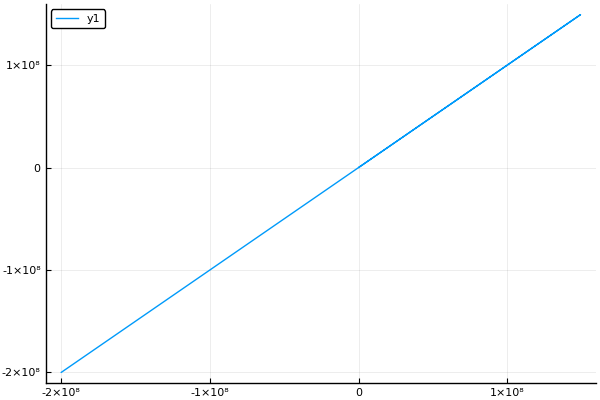

In [76]:
plot(x,U)

In [67]:
uo,u1,x1,inter = Compare(0.5e-4,UL,UR,conL,conR)
uo1,x1 = TimeSolve(uo,x1,inter)

([8930.0 20.0 1.0e9 6.0e7; 8930.0 20.0 1.0e9 6.0e7; … ; 8930.0 4.50734e-10 1.0e9 -0.00171921; 8930.0 4.50734e-10 1.0e9 -0.00171921], [NaN, -0.0015, -0.00025, 0.001, 0.00225, 0.0035, 0.00475, 0.006, 0.00725, 0.0085  …  0.9925, 0.99375, 0.995, 0.99625, 0.9975, 0.99875, 1.0, 1.00125, NaN, 1.00375])

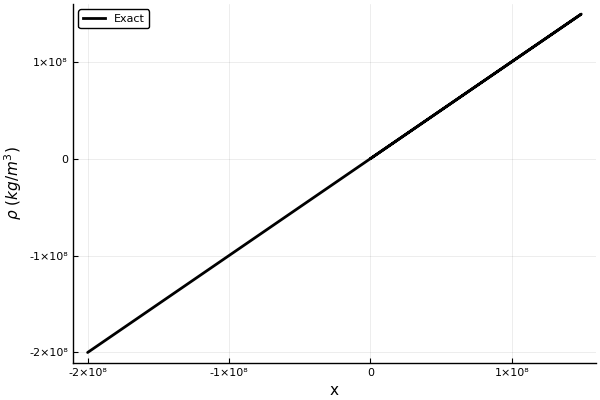

In [75]:
# p1 = plot(x1,uo1[:,1],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot(x  ,U[:,1],xlabel= "x",ylab=L"\rho \  (kg/m^3)", width=2,label="Exact",color="black")
#savefig(p1, "case1rho.pdf")

In [ ]:
 p1 = plot(x1,uo1[:,2],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,2],xlabel= "x",ylab=L"u \  (m/s)", width=2,label="Exact",color="black")
savefig(p1, "case1u.pdf")

In [ ]:
 p1 = plot(x1,uo1[:,3],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,3],xlabel= "x",ylab=L"p \ (Pa)", width=2,label="Exact",color="black")
savefig(p1, "case1p.pdf")

In [ ]:
 p1 = plot(x1,-uo[:,3]+uo1[:,4],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,-U[:,3]+U[:,4],xlabel= "x",ylab=L"\sigma \  (Pa)", width=2,label="Exact",color="black")
savefig(p1, "case1sigma.pdf")

### 2. Two shocks

In [83]:
UL=  [2785,-200.0,1.0,-2.0e8]
UR = [2785,0.0,1.0,-2.0e8]

conL = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)
conR = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)

x, U = Solve(0.5e-4,UL,UR,conL,conR)

([-0.666103, -0.662772, -0.659442, -0.656111, -0.652781, -0.64945, -0.64612, -0.642789, -0.639458, -0.636128  …  0.613797, 0.617028, 0.620258, 0.623489, 0.62672, 0.62995, 0.633181, 0.636411, 0.639642, 0.642872], [2785.0 -200.0 1.0 -2.0e8; 2785.0 -200.0 1.0 -2.0e8; … ; 2785.0 0.0 1.0 -2.0e8; 2785.0 0.0 1.0 -2.0e8])

In [85]:
uo,u1,x1,inter = Compare(0.5e-4,UL,UR,conL,conR)
uo1,x1 = TimeSolve(uo,x1,inter)

([2785.0 -200.0 1.027 -2.0e8; 2785.0 -200.0 1.027 -2.0e8; … ; 2785.0 -1.2275e-10 0.992934 -2.0e8; 2785.0 -1.2275e-10 0.992934 -2.0e8], [NaN, -0.0125, -0.01125, -0.01, -0.00875, -0.0075, -0.00625, -0.005, -0.00375, -0.0025  …  0.9925, 0.99375, 0.995, 0.99625, 0.9975, 0.99875, 1.0, 1.00125, NaN, 1.00375])

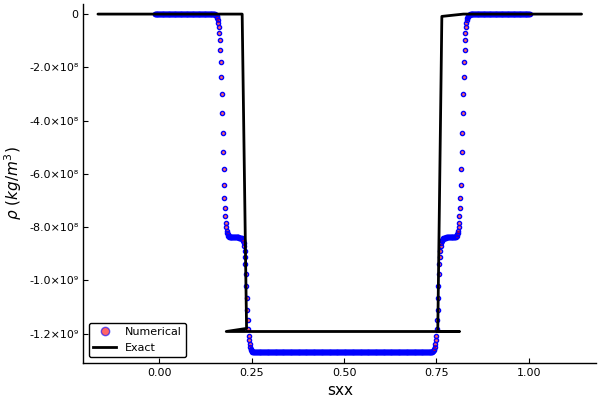

In [88]:
p1 = plot(x1,uo1[:,3],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,3],xlabel= "sxx",ylab=L"\rho \  (kg/m^3)", width=2,label="Exact",color="black")
#savefig(p1, "case2rho.pdf")

In [ ]:
p1 = plot(x1,uo1[:,2],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,2],xlabel= "x",ylab=L"u \  (m/s)", width=2,label="Exact",color="black")
savefig(p1, "case2u.pdf")

In [ ]:
p1 = plot(x1,uo1[:,3],grid=nothing,marker =(3,0.6,Plots.stroke(:red)),color = "white",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,3],xlabel= "x",ylab=L"p \ (Pa)", width=2,label="Exact",color="black")
savefig(p1, "case2p.pdf")

In [ ]:
p1 = plot(x1,uo1[:,4],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,4],xlabel= "x",ylab=L"s_{xx} \  (Pa)", width=2,label="Exact",color="black")
savefig(p1, "case2sxx.pdf")

### 4.  One Elastic  Rarefaction wave

In [ ]:
UL=  [2785,-2.0,1.0e7,0.0]
UR = [2785,2.0,1.0e7,0.0]

conL = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)
conR = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)

x, U = Solve(0.5e-4,UL,UR,conL,conR)

uo,u1,x1,inter = Compare(0.5e-4,UL,UR,conL,conR)
uo1,x1 = TimeSolve(uo,x1,inter)

In [ ]:
p1 = plot(x1,uo1[:,1],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,1],xlabel= "x",ylab=L"\rho \  (kg/m^3)", width=2,label="Exact",color="black")
savefig(p1, "case4rho.pdf")

In [ ]:
p1 = plot(x1,uo1[:,2],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,2],xlabel= "x",ylab=L"u \  (m/s)", width=2,label="Exact",color="black")
savefig(p1, "case4u.pdf")

In [ ]:
p1 = plot(x1,uo1[:,3],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,3],xlabel= "x",ylab=L"p \  (Pa)", width=2,label="Exact",color="black")
savefig(p1, "case4p.pdf")

In [ ]:
p1 = plot(x1,uo1[:,4],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,4],xlabel= "x",ylab=L"sxx \  (Pa)", width=2,label="Exact",color="black")
savefig(p1, "case4sxx.pdf")

### 4.  Two  Rarefaction wave

In [ ]:
UL=  [2785,-40.0,1.0e7,0.0]
UR = [2785,40.0,1.0e7,0.0]

conL = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)
conR = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)

x, U = Solve(0.5e-4,UL,UR,conL,conR)
uo,u1,x1,inter = Compare(0.5e-4,UL,UR,conL,conR)
uo1,x1 = TimeSolve(uo,x1,inter)

In [ ]:
p1 = plot(x1,uo1[:,1],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,1],xlabel= "x",ylab=L"\rho \  (kg/m^3)", width=2,label="Exact",color="black")
savefig(p1, "case3rho.pdf")

In [ ]:
p1 = plot(x1,uo1[:,2],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,2],xlabel= "x",ylab=L"\rho \  (kg/m^3)", width=2,label="Exact",color="black")
savefig(p1, "case3u.pdf")

In [ ]:
p1 = plot(x1,uo1[:,3],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,3],xlabel= "x",ylab=L"\rho \  (kg/m^3)", width=2,label="Exact",color="black")
savefig(p1, "case3p.pdf")

In [ ]:
p1 = plot(x1,uo1[:,4],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,4],xlabel= "x",ylab=L"\rho \  (kg/m^3)", width=2,label="Exact",color="black")
savefig(p1, "case3sxx.pdf")

### 5. Multi-material example

In [ ]:
UL=  [2785,200.0,1.0e-1,0.0]
UR = [8930,0.0,1.0e-1,0.0]

conL = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)
conR = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)


x, U = Solve(0.5e-4,UL,UR,conL,conR)

uo,u1,x1,inter = Compare(0.5e-4,UL,UR,conL,conR)
uo1,x1 = TimeSolve(uo,x1,inter)

In [ ]:
p1 = plot(x1,uo1[:,1],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
plot!(x .+0.5 ,U[:,1],xlabel= "x",ylab=L"\rho \  (kg/m^3)", width=1,label="Exact",color="black")
p2 =  plot(x1,uo1[:,1],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,leg=false,xlims!=[0.0:1.0])
plot!(x .+0.5 ,U[:,1],title="Details", width=1,color="black")
xlims!(0.0,0.35)
ylims!(2780,2860)
p3 =  plot(x1,uo1[:,1],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,leg=false,xlims!=[0.0:1.0])
plot!(x .+0.5 ,U[:,1], width=1,color="black")
xlims!(0.6,0.8)
ylims!(8925,9100)
l=@layout [a [b;c]]
p=plot(p1,p2,p3,layout=l)
savefig(p, "case6rho.pdf")

In [ ]:
p1 = plot(x1,uo1[:,2],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
plot!(x .+0.5 ,U[:,2],xlabel= "x",ylab=L"u\ (m/s)", width=1,label="Exact",color="black")
savefig(p1, "case6u.pdf")

In [ ]:
p1 = plot(x1,uo1[:,3],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
plot!(x .+0.5 ,U[:,3],xlabel= "x",ylab=L"p\ (Pa)", width=1,label="Exact",color="black")
savefig(p1, "case6p.pdf")

In [ ]:
p1 = plot(x1,-uo[:,3]+uo[:,4],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
plot!(x .+0.5 ,-U[:,3]+U[:,4],xlabel= "x",ylab=L"\sigma\ (Pa)", width=1,label="Exact",color="black")
savefig(p1, "case6sigma.pdf")

### 6. Multi-example 2

In [ ]:
UL=  [8930,0.0,1.0e10,0.0]
UR = [2785,0.0,1.0e1,0.0]

conL = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
conR = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)

x, U = Solve(0.5e-4,UL,UR,conL,conR)

uo,u1,x1,inter = Compare(0.5e-4,UL,UR,conL,conR)
uo1,x1 = TimeSolve(uo,x1,inter)

In [ ]:
p1 = plot(x1,uo1[:,1],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
plot!(x .+0.5 ,U[:,1],xlabel= "x",ylab=L"\rho \  (kg/m^3)", width=1,label="Exact",color="black")
p2 =  plot(x1,uo1[:,1],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,leg=false,xlims!=[0.0:1.0])
plot!(x .+0.5 ,U[:,1],title="Details", width=1,color="black")
xlims!(0.23,0.3)
ylims!(8900,8940)
p3 =  plot(x1,uo1[:,1],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,leg=false,xlims!=[0.0:1.0])
plot!(x .+0.5 ,U[:,1], width=1,color="black")
xlims!(0.73,0.9)
ylims!(2780,2906)
l=@layout [a [b;c]]
p=plot(p1,p2,p3,layout=l)
savefig(p, "case8rho.pdf")

In [ ]:
p1 = plot(x1,uo1[:,2],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
plot!(x .+0.5 ,U[:,2],xlabel= "x",ylab=L"u\ (m/s)", width=1,label="Exact",color="black")
savefig(p1, "case8u.pdf")

In [ ]:
p1 = plot(x1,uo1[:,3],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
plot!(x .+0.5 ,U[:,3],xlabel= "x",ylab=L"p\ (Pa)", width=1,label="Exact",color="black")
savefig(p1, "case8p.pdf")

In [ ]:
p1 = plot(x1,-uo1[:,3]+uo[:,4],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
plot!(x .+0.5 ,-U[:,3]+U[:,4],xlabel= "x",ylab=L"\sigma\ (Pa)", width=1,label="Exact",color="black")
savefig(p1, "case8sigma.pdf")

### Comparason numerical results

In [ ]:
plot(iris, x=:SepalLength, y =:SepalWidth, Geom.line)

In [ ]:
UL=  [2785,40.0,1.0e8,-2.0e8]
UR = [2785,-40.0,1.0e2,0.0]

conL = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)
conR = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)

x, U = Solve(0.5e-4,UL,UR,conL,conR)
uo,u1,x1,inter = Compare(0.5e-4,UL,UR,conL,conR)
uo1,x1 = TimeSolve(uo,x1,inter)

In [ ]:
p1 = plot(x1,uo1[:,1],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,1],xlabel= "x",ylab=L"\rho \  (kg/m^3)", width=2,label="Exact",color="black")
savefig(p1, "case5rho.pdf")

In [ ]:
p1 = plot(x1,uo1[:,2],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
plot!(x .+0.5 ,U[:,2],xlabel= "x",ylab=L"u\ (m/s)", width=2,label="Exact",color="black")
savefig(p1, "case5u.pdf")

In [ ]:
p1 = plot(x1,uo1[:,3],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
plot!(x .+0.5 ,U[:,3],xlabel= "x",ylab=L"p\ (Pa)", width=2,label="Exact",color="black")
savefig(p1, "case5p.pdf")

In [ ]:
p1 = plot(x1,uo[:,4],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
plot!(x .+0.5 ,U[:,4],xlabel= "x",ylab=L"s_{xx}\ (Pa)", width=2,label="Exact",color="black")
savefig(p1, "case5sxx.pdf")

In [164]:
UL=  [2785,0.0,1.0e10,0.0]
UR = [2785,0.0,1.0e2,0.0]

#conL = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
conL = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)
conR = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)

@btime x, U = R(0.5e-4,UL,UR,conL,conR)
#uo,u1,x1,inter = Compare(0.5e-4,UL,UR,conL,conR)
#uo1,x1 = TimeSolve(uo,x1,inter)

F = [0.0, -1.0e10]
(caseL, caseR) = (Rare(2), Shock(4))
F = [1.51602, -2.49433e9]
(caseL, caseR) = (Rare(2), Shock(4))
F = [-0.591929, 6.70119e6]
(caseL, caseR) = (Rare(2), Shock(4))
F = [-1.43734e-5, 1061.23]
(caseL, caseR) = (Rare(2), Shock(4))
(sLSlow, sLMid, sLFast) = (-6984.451092964855, -6904.381515036783, -5214.996564634679)
(sR, s̃R) = (6490.425973221977, 5788.981416694145)


([2785.0 7.37864e-14 1.0e10 2.00029e-5; 2785.0 7.37864e-14 1.0e10 2.00029e-5; … ; 2785.0 5.90637e-10 99.993 -0.00103187; 2785.0 5.90637e-10 99.993 -0.00103187], [NaN, -0.0025, -0.00125, 1.09008e-19, 0.00125, 0.0025, 0.00375, 0.005, 0.00625, 0.0075  …  0.9925, 0.99375, 0.995, 0.99625, 0.9975, 0.99875, 1.0, 1.00125, NaN, 1.00375])

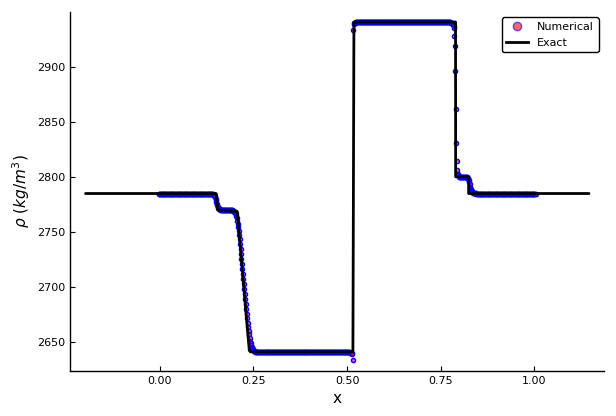

In [165]:
p1 = plot(x1,uo1[:,1],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
 plot!(x .+0.5 ,U[:,1],xlabel= "x",ylab=L"\rho \  (kg/m^3)", width=2,label="Exact",color="black")
savefig(p1, "case9rho.pdf")

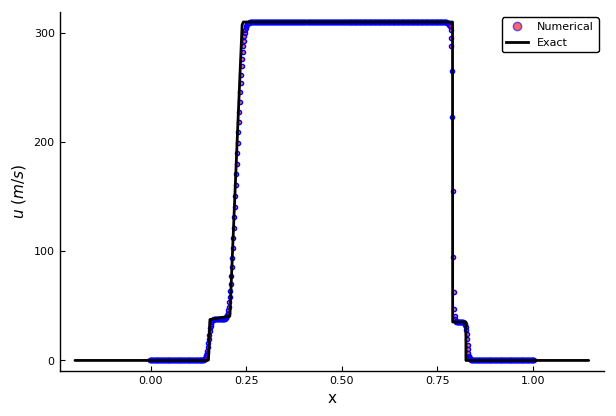

In [166]:
p1 = plot(x1,uo1[:,2],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
plot!(x .+0.5 ,U[:,2],xlabel= "x",ylab=L"u\ (m/s)", width=2,label="Exact",color="black")
savefig(p1, "case9u.pdf")

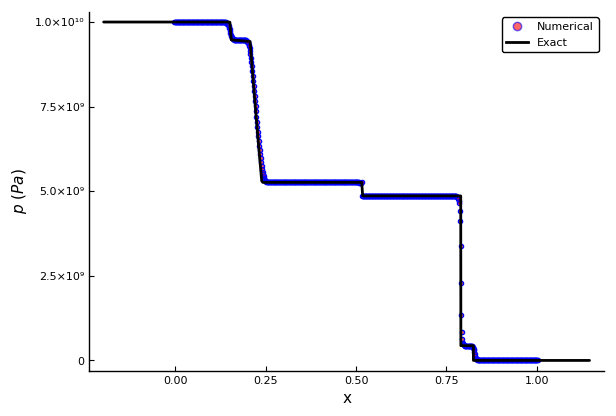

In [167]:
p1 = plot(x1,uo1[:,3],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
plot!(x .+0.5 ,U[:,3],xlabel= "x",ylab=L"p\ (Pa)", width=2,label="Exact",color="black")
savefig(p1, "case9p.pdf")

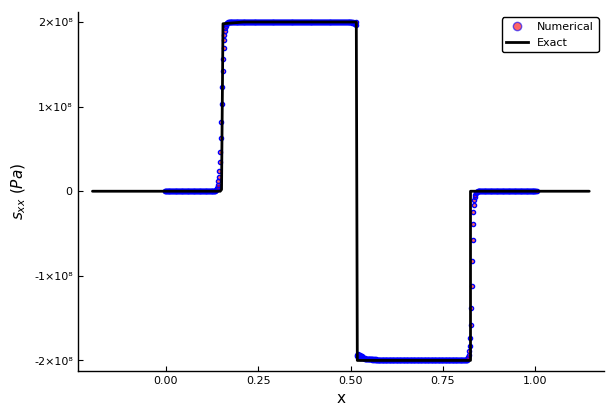

In [168]:
p1 = plot(x1,uo[:,4],grid=nothing,marker =(3,0.6,Plots.stroke(:blue)),color = "red",width=1,line=nothing,label = "Numerical",xlims!=[0.0:1.0])
plot!(x .+0.5 ,U[:,4],xlabel= "x",ylab=L"s_{xx}\ (Pa)", width=2,label="Exact",color="black")
savefig(p1, "case9sxx.pdf")